Este notebook y todos los que tienen un nombre similar a este son prácticamente iguales. Su contenido también es muy similar al del notebook "IBM_MSE", la principal diferencia es que en esta serie de notebooks, en lugar de utilizar una secuencia temporal diaria, utilizo una secuencia temporal en la que los días van de 2 en 2, de 3 en 3...

El objetivo es tener diferentes modelos que puedan hacer predicciones en este orden (el de "IBM_MSE" hará las predicciones para hoy, el de 2 días las hará para mañana, el de 3 para pasado mañana, etc.)

Veremos como según vamos aumentando el tamaño de los saltos en el tiempo, los modelos empiezan a ser cada vez más imprecisos. El objetivo no es conseguir predicciones exactas, ya que creo que se trata de una tarea imposible, sino que al final lo que busco con estos modelos es tener un conjunto de predicciones que me puedan, en cierto modo y de forma conjunta, "asegurar" que los valores van a seguir una cierta tendencia.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 4

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 4 in 4 days

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised test chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 1s 377us/step - loss: 0.1201 - val_loss: 0.0517
Epoch 2/24
3891/3891 [==============================] - 1s 149us/step - loss: 0.0152 - val_loss: 0.0153
Epoch 3/24
3891/3891 [==============================] - 1s 149us/step - loss: 0.0062 - val_loss: 0.0062
Epoch 4/24
3891/3891 [==============================] - 1s 151us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/24
3891/3891 [==============================] - 1s 152us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 6/24
3891/3891 [==============================] - 1s 153us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/24
3891/3891 [==============================] - 1s 153us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/24
3891/3891 [==============================] - 1s 153us/step - loss: 0.0011 - val

Epoch 8/24
3891/3891 [==============================] - 2s 464us/step - loss: nan - val_loss: nan
Epoch 9/24
3891/3891 [==============================] - 2s 462us/step - loss: nan - val_loss: nan
Epoch 10/24
3891/3891 [==============================] - 2s 463us/step - loss: nan - val_loss: nan
Epoch 11/24
3891/3891 [==============================] - 2s 462us/step - loss: nan - val_loss: nan
Epoch 12/24
3891/3891 [==============================] - 2s 460us/step - loss: nan - val_loss: nan
Epoch 13/24
3891/3891 [==============================] - 2s 462us/step - loss: nan - val_loss: nan
Epoch 14/24
3891/3891 [==============================] - 2s 461us/step - loss: nan - val_loss: nan
Epoch 15/24
3891/3891 [==============================] - 2s 465us/step - loss: nan - val_loss: nan
Epoch 16/24
3891/3891 [==============================] - 2s 461us/step - loss: nan - val_loss: nan
Epoch 17/24
3891/3891 [==============================] - 2s 462us/step - loss: nan - val_loss: nan
Epoch 18/24


3891/3891 [==============================] - 2s 529us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 21/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 22/24
3891/3891 [==============================] - 2s 530us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 23/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 24/24
3891/3891 [==============================] - 2s 529us/step - loss: 0.0011 - val_loss: 0.0011
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 4s 919us/step - loss: 0.0561 - val_loss: 0.0178
Epoch 2/24
3891/3891 [==============================] - 2s 531us/step - loss: 0.0136 - val_loss: 0.0074
Epoch 3/24
3891/3891 [==============================] - 2s 531us/step - loss: 0.0063 - val_loss: 0.0108
Epoch 4/24
3891/3891 [==============================] - 2s 536us/step - loss: 0.0045 - val_loss: 0.0021
Epoch 5/24
3891/3891 [==

3891/3891 [==============================] - 4s 1ms/step - loss: 0.1255 - val_loss: 0.0054
Epoch 2/24
3891/3891 [==============================] - 2s 558us/step - loss: 0.0218 - val_loss: 0.0155
Epoch 3/24
3891/3891 [==============================] - 2s 556us/step - loss: 0.0178 - val_loss: 0.0232
Epoch 4/24
3891/3891 [==============================] - 2s 557us/step - loss: 0.0147 - val_loss: 0.0108
Epoch 5/24
3891/3891 [==============================] - 2s 557us/step - loss: 0.0098 - val_loss: 0.0142
Epoch 6/24
3891/3891 [==============================] - 2s 557us/step - loss: 0.0101 - val_loss: 0.0082
Epoch 7/24
3891/3891 [==============================] - 2s 561us/step - loss: 0.0081 - val_loss: 0.0091
Epoch 8/24
3891/3891 [==============================] - 2s 557us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 9/24
3891/3891 [==============================] - 2s 560us/step - loss: 0.0077 - val_loss: 0.0065
Epoch 10/24
3891/3891 [==============================] - 2s 558us/step - loss

3891/3891 [==============================] - 2s 528us/step - loss: 0.0090 - val_loss: 0.0117
Epoch 13/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0110 - val_loss: 0.0185
Epoch 14/24
3891/3891 [==============================] - 2s 528us/step - loss: 0.0089 - val_loss: 0.0231
Epoch 15/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0129 - val_loss: 0.0150
Epoch 16/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0081 - val_loss: 0.0151
Epoch 17/24
3891/3891 [==============================] - 2s 524us/step - loss: 0.0122 - val_loss: 0.0290
Epoch 18/24
3891/3891 [==============================] - 2s 526us/step - loss: 0.0111 - val_loss: 0.0103
Epoch 19/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0064 - val_loss: 0.0197
Epoch 20/24
3891/3891 [==============================] - 2s 528us/step - loss: 0.0080 - val_loss: 0.0128
Epoch 21/24
3891/3891 [==============================] - 2s 528us/s

3891/3891 [==============================] - 1s 157us/step - loss: 7.6293e-04 - val_loss: 7.6668e-04
Epoch 24/24
3891/3891 [==============================] - 1s 153us/step - loss: 7.4560e-04 - val_loss: 8.8206e-04
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 3s 816us/step - loss: 0.0823 - val_loss: 0.0113
Epoch 2/24
3891/3891 [==============================] - 1s 153us/step - loss: 0.0094 - val_loss: 0.0023
Epoch 3/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0035 - val_loss: 0.0014
Epoch 4/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0022 - val_loss: 0.0038
Epoch 5/24
3891/3891 [==============================] - 1s 154us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/24
3891/3891 [==============================] - 1s 152us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/24


Epoch 7/24
3891/3891 [==============================] - 1s 356us/step - loss: 0.0313 - val_loss: 0.0044
Epoch 8/24
3891/3891 [==============================] - 1s 354us/step - loss: 0.0197 - val_loss: 0.0057
Epoch 9/24
3891/3891 [==============================] - 1s 354us/step - loss: 0.0126 - val_loss: 0.0056
Epoch 10/24
3891/3891 [==============================] - 2s 401us/step - loss: 0.0081 - val_loss: 0.0048
Epoch 11/24
3891/3891 [==============================] - 1s 378us/step - loss: 0.0057 - val_loss: 0.0026
Epoch 12/24
3891/3891 [==============================] - 1s 376us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 13/24
3891/3891 [==============================] - 1s 381us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 14/24
3891/3891 [==============================] - 1s 379us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 15/24
3891/3891 [==============================] - 1s 374us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 16/24
3891/3891 [==============================] - 1

Epoch 11/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/24
3891/3891 [==============================] - 1s 155us/step - loss: 9.8914e-04 - val_loss: 0.0011
Epoch 13/24
3891/3891 [==============================] - 1s 154us/step - loss: 8.9909e-04 - val_loss: 0.0010
Epoch 14/24
3891/3891 [==============================] - 1s 156us/step - loss: 8.3606e-04 - val_loss: 8.5571e-04
Epoch 15/24
3891/3891 [==============================] - 1s 161us/step - loss: 7.9894e-04 - val_loss: 7.9675e-04
Epoch 16/24
3891/3891 [==============================] - 1s 154us/step - loss: 7.7501e-04 - val_loss: 9.4994e-04
Epoch 17/24
3891/3891 [==============================] - 1s 155us/step - loss: 8.4704e-04 - val_loss: 7.7641e-04
Epoch 18/24
3891/3891 [==============================] - 1s 156us/step - loss: 7.7723e-04 - val_loss: 8.2433e-04
Epoch 19/24
3891/3891 [==============================] - 1s 153us/step - loss: 8.1000e-04 - val_loss: 8.2460e-04

3891/3891 [==============================] - 1s 319us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 16/24
3891/3891 [==============================] - 1s 319us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 17/24
3891/3891 [==============================] - 1s 321us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 18/24
3891/3891 [==============================] - 1s 321us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 19/24
3891/3891 [==============================] - 1s 321us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 20/24
3891/3891 [==============================] - 1s 321us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 21/24
3891/3891 [==============================] - 1s 320us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 22/24
3891/3891 [==============================] - 1s 320us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 23/24
3891/3891 [==============================] - 1s 320us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 24/24
3891/3891 [==============================] - 1s 321us/s

Epoch 23/24
3891/3891 [==============================] - 2s 402us/step - loss: 0.0058 - val_loss: 0.0035
Epoch 24/24
3891/3891 [==============================] - 2s 399us/step - loss: 0.0056 - val_loss: 0.0034
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 6s 2ms/step - loss: 0.0664 - val_loss: 0.0103
Epoch 2/24
3891/3891 [==============================] - 2s 401us/step - loss: 0.0226 - val_loss: 0.0060
Epoch 3/24
3891/3891 [==============================] - 2s 398us/step - loss: 0.0177 - val_loss: 0.0045
Epoch 4/24
3891/3891 [==============================] - 2s 398us/step - loss: 0.0134 - val_loss: 0.0038
Epoch 5/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0107 - val_loss: 0.0031
Epoch 6/24
3891/3891 [==============================] - 2s 399us/step - loss: 0.0088 - val_loss: 0.0025
Epoch 7/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0074 - val_loss: 0.0023
Epoch 8/24
3891/3

Epoch 3/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0124 - val_loss: 0.0035
Epoch 4/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0055 - val_loss: 0.0021
Epoch 5/24
3891/3891 [==============================] - 1s 154us/step - loss: 0.0048 - val_loss: 0.0064
Epoch 6/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 7/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 10/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 11/24
3891/3891 [==============================] - 1s 155us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/24
3891/3891 [==============================] - 1s 15

Epoch 16/24
3891/3891 [==============================] - 2s 521us/step - loss: 0.0055 - val_loss: 0.0027
Epoch 17/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0050 - val_loss: 0.0029
Epoch 18/24
3891/3891 [==============================] - 2s 521us/step - loss: 0.0052 - val_loss: 0.0023
Epoch 19/24
3891/3891 [==============================] - 2s 519us/step - loss: 0.0054 - val_loss: 0.0026
Epoch 20/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0050 - val_loss: 0.0027
Epoch 21/24
3891/3891 [==============================] - 2s 520us/step - loss: 0.0050 - val_loss: 0.0023
Epoch 22/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0047 - val_loss: 0.0024
Epoch 23/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0047 - val_loss: 0.0027
Epoch 24/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0046 - val_loss: 0.0027

GENERATION 6

Train on 3891 samples, validate on 433 s

3891/3891 [==============================] - 1s 158us/step - loss: 0.0014 - val_loss: 0.0039
Epoch 21/24
3891/3891 [==============================] - 1s 156us/step - loss: 0.0014 - val_loss: 0.0047
Epoch 22/24
3891/3891 [==============================] - 1s 158us/step - loss: 0.0013 - val_loss: 0.0054
Epoch 23/24
3891/3891 [==============================] - 1s 157us/step - loss: 0.0013 - val_loss: 0.0062
Epoch 24/24
3891/3891 [==============================] - 1s 157us/step - loss: 0.0013 - val_loss: 0.0049
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 8s 2ms/step - loss: 0.1473 - val_loss: 0.0032
Epoch 2/24
3891/3891 [==============================] - 1s 324us/step - loss: 0.0181 - val_loss: 0.0132
Epoch 3/24
3891/3891 [==============================] - 1s 321us/step - loss: 0.0127 - val_loss: 0.0176
Epoch 4/24
3891/3891 [==============================] - 1s 322us/step - loss: 0.0074 - val_loss: 0.0040
Epoch 5/24
3891/3891 [====

3891/3891 [==============================] - 9s 2ms/step - loss: 0.2570 - val_loss: 0.0060
Epoch 2/24
3891/3891 [==============================] - 2s 485us/step - loss: 0.0743 - val_loss: 0.0953
Epoch 3/24
3891/3891 [==============================] - 2s 485us/step - loss: 0.0853 - val_loss: 0.0872
Epoch 4/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0736 - val_loss: 0.0374
Epoch 5/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0684 - val_loss: 0.0238
Epoch 6/24
3891/3891 [==============================] - 2s 489us/step - loss: 0.0690 - val_loss: 0.0305
Epoch 7/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0678 - val_loss: 0.0407
Epoch 8/24
3891/3891 [==============================] - 2s 486us/step - loss: 0.0679 - val_loss: 0.0409
Epoch 9/24
3891/3891 [==============================] - 2s 485us/step - loss: 0.0679 - val_loss: 0.0356
Epoch 10/24
3891/3891 [==============================] - 2s 486us/step - loss

3891/3891 [==============================] - 1s 157us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/24
3891/3891 [==============================] - 1s 158us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/24
3891/3891 [==============================] - 1s 159us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/24
3891/3891 [==============================] - 1s 159us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/24
3891/3891 [==============================] - 1s 159us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/24
3891/3891 [==============================] - 1s 159us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 12/24
3891/3891 [==============================] - 1s 159us/step - loss: 9.5209e-04 - val_loss: 0.0011
Epoch 13/24
3891/3891 [==============================] - 1s 159us/step - loss: 9.0173e-04 - val_loss: 9.6059e-04
Epoch 14/24
3891/3891 [==============================] - 1s 159us/step - loss: 8.5042e-04 - val_loss: 9.1288e-04
Epoch 15/24
3891/3891 [===========================

3891/3891 [==============================] - 1s 254us/step - loss: 0.0053 - val_loss: 0.0014
Epoch 14/24
3891/3891 [==============================] - 1s 253us/step - loss: 0.0041 - val_loss: 0.0019
Epoch 15/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0069 - val_loss: 0.0011
Epoch 16/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 17/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0047 - val_loss: 0.0014
Epoch 18/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 19/24
3891/3891 [==============================] - 1s 252us/step - loss: 0.0047 - val_loss: 0.0011
Epoch 20/24
3891/3891 [==============================] - 1s 254us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 21/24
3891/3891 [==============================] - 1s 254us/step - loss: 0.0054 - val_loss: 0.0012
Epoch 22/24
3891/3891 [==============================] - 1s 252us/s

Epoch 18/24
3891/3891 [==============================] - 1s 315us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 19/24
3891/3891 [==============================] - 1s 308us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 20/24
3891/3891 [==============================] - 1s 309us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 21/24
3891/3891 [==============================] - 1s 310us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 22/24
3891/3891 [==============================] - 1s 309us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/24
3891/3891 [==============================] - 1s 309us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 24/24
3891/3891 [==============================] - 1s 309us/step - loss: 0.0014 - val_loss: 0.0014
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 9s 2ms/step - loss: 0.1224 - val_loss: 0.0521
Epoch 2/24
3891/3891 [==============================] - 1s 159us/step - loss: 0.0213 - val_loss: 0.0185
Epoch 3/24
3

3891/3891 [==============================] - 1s 361us/step - loss: 0.0753 - val_loss: 0.0758
Epoch 3/24
3891/3891 [==============================] - 1s 361us/step - loss: 0.0570 - val_loss: 0.0508
Epoch 4/24
3891/3891 [==============================] - 1s 362us/step - loss: 0.0494 - val_loss: 0.0519
Epoch 5/24
3891/3891 [==============================] - 1s 363us/step - loss: 0.0400 - val_loss: 0.0403
Epoch 6/24
3891/3891 [==============================] - 1s 361us/step - loss: 0.0373 - val_loss: 0.0562
Epoch 7/24
3891/3891 [==============================] - 1s 363us/step - loss: 0.0307 - val_loss: 0.0649
Epoch 8/24
3891/3891 [==============================] - 1s 363us/step - loss: 0.0377 - val_loss: 0.0352
Epoch 9/24
3891/3891 [==============================] - 1s 364us/step - loss: 0.0319 - val_loss: 0.0521
Epoch 10/24
3891/3891 [==============================] - 1s 364us/step - loss: 0.0196 - val_loss: 0.0857
Epoch 11/24
3891/3891 [==============================] - 1s 363us/step - l

Epoch 7/24
3891/3891 [==============================] - 1s 161us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/24
3891/3891 [==============================] - 1s 161us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/24
3891/3891 [==============================] - 1s 160us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/24
3891/3891 [==============================] - 1s 162us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 11/24
3891/3891 [==============================] - 1s 161us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/24
3891/3891 [==============================] - 1s 161us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 13/24
3891/3891 [==============================] - 1s 161us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 14/24
3891/3891 [==============================] - 1s 160us/step - loss: 9.8695e-04 - val_loss: 0.0010
Epoch 15/24
3891/3891 [==============================] - 1s 160us/step - loss: 9.2358e-04 - val_loss: 9.5912e-04
Epoch 16/24
3891/3891 [=======================

Epoch 12/24
3891/3891 [==============================] - 1s 158us/step - loss: nan - val_loss: nan
Epoch 13/24
3891/3891 [==============================] - 1s 159us/step - loss: nan - val_loss: nan
Epoch 14/24
3891/3891 [==============================] - 1s 159us/step - loss: nan - val_loss: nan
Epoch 15/24
3891/3891 [==============================] - 1s 159us/step - loss: nan - val_loss: nan
Epoch 16/24
3891/3891 [==============================] - 1s 160us/step - loss: nan - val_loss: nan
Epoch 17/24
3891/3891 [==============================] - 1s 159us/step - loss: nan - val_loss: nan
Epoch 18/24
3891/3891 [==============================] - 1s 159us/step - loss: nan - val_loss: nan
Epoch 19/24
3891/3891 [==============================] - 1s 159us/step - loss: nan - val_loss: nan
Epoch 20/24
3891/3891 [==============================] - 1s 163us/step - loss: nan - val_loss: nan
Epoch 21/24
3891/3891 [==============================] - 1s 162us/step - loss: nan - val_loss: nan
Epoch 22/2

3891/3891 [==============================] - 1s 262us/step - loss: 0.0108 - val_loss: 0.0017
Epoch 3/24
3891/3891 [==============================] - 1s 262us/step - loss: 0.0050 - val_loss: 0.0024
Epoch 4/24
3891/3891 [==============================] - 1s 263us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 5/24
3891/3891 [==============================] - 1s 263us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 6/24
3891/3891 [==============================] - 1s 262us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/24
3891/3891 [==============================] - 1s 262us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/24
3891/3891 [==============================] - 1s 262us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/24
3891/3891 [==============================] - 1s 260us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/24
3891/3891 [==============================] - 1s 263us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 11/24
3891/3891 [==============================] - 1s 263us/step - l

3891/3891 [==============================] - 1s 337us/step - loss: nan - val_loss: nan
Epoch 18/24
3891/3891 [==============================] - 1s 335us/step - loss: nan - val_loss: nan
Epoch 19/24
3891/3891 [==============================] - 1s 336us/step - loss: nan - val_loss: nan
Epoch 20/24
3891/3891 [==============================] - 1s 335us/step - loss: nan - val_loss: nan
Epoch 21/24
3891/3891 [==============================] - 1s 335us/step - loss: nan - val_loss: nan
Epoch 22/24
3891/3891 [==============================] - 1s 336us/step - loss: nan - val_loss: nan
Epoch 23/24
3891/3891 [==============================] - 1s 337us/step - loss: nan - val_loss: nan
Epoch 24/24
3891/3891 [==============================] - 1s 334us/step - loss: nan - val_loss: nan

GENERATION 11

Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 14s 4ms/step - loss: 0.1738 - val_loss: 0.0150
Epoch 2/24
3891/3891 [==============================] 

3891/3891 [==============================] - 1s 246us/step - loss: 0.0033 - val_loss: 0.0039
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 16s 4ms/step - loss: nan - val_loss: nan
Epoch 2/24
3891/3891 [==============================] - 1s 378us/step - loss: nan - val_loss: nan
Epoch 3/24
3891/3891 [==============================] - 1s 385us/step - loss: nan - val_loss: nan
Epoch 4/24
3891/3891 [==============================] - 1s 377us/step - loss: nan - val_loss: nan
Epoch 5/24
3891/3891 [==============================] - 1s 377us/step - loss: nan - val_loss: nan
Epoch 6/24
3891/3891 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 7/24
3891/3891 [==============================] - 1s 378us/step - loss: nan - val_loss: nan
Epoch 8/24
3891/3891 [==============================] - 1s 377us/step - loss: nan - val_loss: nan
Epoch 9/24
3891/3891 [==============================] - 1s 380us/step - loss:

3891/3891 [==============================] - 2s 490us/step - loss: 0.0088 - val_loss: 0.0120
Epoch 13/24
3891/3891 [==============================] - 2s 492us/step - loss: 0.0072 - val_loss: 0.0077
Epoch 14/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0099 - val_loss: 0.0048
Epoch 15/24
3891/3891 [==============================] - 2s 494us/step - loss: 0.0054 - val_loss: 0.0098
Epoch 16/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0077 - val_loss: 0.0090
Epoch 17/24
3891/3891 [==============================] - 2s 494us/step - loss: 0.0071 - val_loss: 0.0113
Epoch 18/24
3891/3891 [==============================] - 2s 493us/step - loss: 0.0067 - val_loss: 0.0047
Epoch 19/24
3891/3891 [==============================] - 2s 492us/step - loss: 0.0067 - val_loss: 0.0107
Epoch 20/24
3891/3891 [==============================] - 2s 494us/step - loss: 0.0067 - val_loss: 0.0068
Epoch 21/24
3891/3891 [==============================] - 2s 495us/s

3891/3891 [==============================] - 2s 543us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 18/24
3891/3891 [==============================] - 2s 543us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 19/24
3891/3891 [==============================] - 2s 545us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 20/24
3891/3891 [==============================] - 2s 546us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 21/24
3891/3891 [==============================] - 2s 545us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 22/24
3891/3891 [==============================] - 2s 541us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 23/24
3891/3891 [==============================] - 2s 541us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 24/24
3891/3891 [==============================] - 2s 545us/step - loss: 0.0018 - val_loss: 0.0017
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 19s 5ms/step - loss: 0.9789 - val_loss: 0.0181
Epoch 2/24
3891/3891 [

Epoch 22/24
3891/3891 [==============================] - 1s 330us/step - loss: 0.0613 - val_loss: 0.0335
Epoch 23/24
3891/3891 [==============================] - 1s 330us/step - loss: 0.0609 - val_loss: 0.0329
Epoch 24/24
3891/3891 [==============================] - 1s 338us/step - loss: 0.0606 - val_loss: 0.0325
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 19s 5ms/step - loss: 0.1586 - val_loss: 0.0042
Epoch 2/24
3891/3891 [==============================] - 1s 168us/step - loss: 0.0195 - val_loss: 0.0192
Epoch 3/24
3891/3891 [==============================] - 1s 167us/step - loss: 0.0097 - val_loss: 0.0067
Epoch 4/24
3891/3891 [==============================] - 1s 166us/step - loss: 0.0042 - val_loss: 0.0029
Epoch 5/24
3891/3891 [==============================] - 1s 167us/step - loss: 0.0025 - val_loss: 0.0038
Epoch 6/24
3891/3891 [==============================] - 1s 168us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/24
3891

Epoch 2/24
3891/3891 [==============================] - 1s 188us/step - loss: 0.0097 - val_loss: 0.0080
Epoch 3/24
3891/3891 [==============================] - 1s 188us/step - loss: 0.0060 - val_loss: 0.0012
Epoch 4/24
3891/3891 [==============================] - 1s 187us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 5/24
3891/3891 [==============================] - 1s 189us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 6/24
3891/3891 [==============================] - 1s 189us/step - loss: 0.0037 - val_loss: 0.0012
Epoch 7/24
3891/3891 [==============================] - 1s 188us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 8/24
3891/3891 [==============================] - 1s 187us/step - loss: 0.0034 - val_loss: 0.0018
Epoch 9/24
3891/3891 [==============================] - 1s 188us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 10/24
3891/3891 [==============================] - 1s 188us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 11/24
3891/3891 [==============================] - 1s 188

3891/3891 [==============================] - 2s 503us/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/24
3891/3891 [==============================] - 2s 498us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/24
3891/3891 [==============================] - 2s 498us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/24
3891/3891 [==============================] - 2s 496us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 11/24
3891/3891 [==============================] - 2s 499us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 12/24
3891/3891 [==============================] - 2s 497us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 13/24
3891/3891 [==============================] - 2s 497us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 14/24
3891/3891 [==============================] - 2s 494us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 15/24
3891/3891 [==============================] - 2s 499us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 16/24
3891/3891 [==============================] - 2s 496us/ste

3891/3891 [==============================] - 1s 169us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/24
3891/3891 [==============================] - 1s 169us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 13/24
3891/3891 [==============================] - 1s 169us/step - loss: 9.7916e-04 - val_loss: 0.0010
Epoch 14/24
3891/3891 [==============================] - 1s 170us/step - loss: 9.0297e-04 - val_loss: 9.3985e-04
Epoch 15/24
3891/3891 [==============================] - 1s 168us/step - loss: 8.4041e-04 - val_loss: 8.2552e-04
Epoch 16/24
3891/3891 [==============================] - 1s 169us/step - loss: 7.9206e-04 - val_loss: 7.9471e-04
Epoch 17/24
3891/3891 [==============================] - 1s 171us/step - loss: 7.6442e-04 - val_loss: 7.9525e-04
Epoch 18/24
3891/3891 [==============================] - 1s 170us/step - loss: 7.5610e-04 - val_loss: 7.5296e-04
Epoch 19/24
3891/3891 [==============================] - 1s 169us/step - loss: 7.3474e-04 - val_loss: 7.3867e-04
Epoch 20/24
389

3891/3891 [==============================] - 2s 523us/step - loss: 0.0043 - val_loss: 0.0023
Epoch 21/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0042 - val_loss: 0.0023
Epoch 22/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0041 - val_loss: 0.0022
Epoch 23/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0042 - val_loss: 0.0023
Epoch 24/24
3891/3891 [==============================] - 2s 521us/step - loss: 0.0041 - val_loss: 0.0023
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 25s 6ms/step - loss: 1.6166 - val_loss: 1.2330
Epoch 2/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.6451 - val_loss: 0.5061
Epoch 3/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.2355 - val_loss: 0.1825
Epoch 4/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0957 - val_loss: 0.0575
Epoch 5/24
3891/3891 [===

Epoch 24/24
3891/3891 [==============================] - 1s 172us/step - loss: 7.4088e-04 - val_loss: 7.4498e-04
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 24s 6ms/step - loss: 0.0768 - val_loss: 0.0266
Epoch 2/24
3891/3891 [==============================] - 1s 172us/step - loss: 0.0104 - val_loss: 0.0062
Epoch 3/24
3891/3891 [==============================] - 1s 176us/step - loss: 0.0046 - val_loss: 0.0040
Epoch 4/24
3891/3891 [==============================] - 1s 173us/step - loss: 0.0025 - val_loss: 0.0015
Epoch 5/24
3891/3891 [==============================] - 1s 172us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/24
3891/3891 [==============================] - 1s 171us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/24
3891/3891 [==============================] - 1s 172us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/24
3891/3891 [==============================] - 1s 172us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/2

Epoch 4/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 5/24
3891/3891 [==============================] - 2s 509us/step - loss: 0.0039 - val_loss: 0.0031
Epoch 6/24
3891/3891 [==============================] - 2s 513us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 7/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 8/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/24
3891/3891 [==============================] - 2s 507us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 10/24
3891/3891 [==============================] - 2s 508us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 11/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 12/24
3891/3891 [==============================] - 2s 510us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 13/24
3891/3891 [==============================] - 2s 5

3891/3891 [==============================] - 2s 523us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 11/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 12/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 13/24
3891/3891 [==============================] - 2s 521us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 14/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 15/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 16/24
3891/3891 [==============================] - 2s 523us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 17/24
3891/3891 [==============================] - 2s 526us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 18/24
3891/3891 [==============================] - 2s 527us/s

3891/3891 [==============================] - 2s 525us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 19/24
3891/3891 [==============================] - 2s 532us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 20/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 21/24
3891/3891 [==============================] - 2s 526us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 22/24
3891/3891 [==============================] - 2s 529us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 23/24
3891/3891 [==============================] - 2s 524us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 24/24
3891/3891 [==============================] - 2s 526us/step - loss: 0.0016 - val_loss: 0.0022
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 30s 8ms/step - loss: 0.0853 - val_loss: 0.0175
Epoch 2/24
3891/3891 [==============================] - 2s 528us/step - loss: 0.0093 - val_loss: 0.0073
Epoch 3/24
3891/3891 [=

3891/3891 [==============================] - 2s 396us/step - loss: 0.0030 - val_loss: 0.0038
Epoch 24/24
3891/3891 [==============================] - 2s 397us/step - loss: 0.0046 - val_loss: 0.0015

GENERATION 17

Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 32s 8ms/step - loss: 0.1583 - val_loss: 0.0923
Epoch 2/24
3891/3891 [==============================] - 1s 368us/step - loss: 0.0260 - val_loss: 0.0107
Epoch 3/24
3891/3891 [==============================] - 1s 367us/step - loss: 0.0085 - val_loss: 0.0025
Epoch 4/24
3891/3891 [==============================] - 1s 370us/step - loss: 0.0046 - val_loss: 0.0069
Epoch 5/24
3891/3891 [==============================] - 1s 370us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/24
3891/3891 [==============================] - 1s 375us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/24
3891/3891 [==============================] - 1s 369us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 8/24
3

Epoch 3/24
3891/3891 [==============================] - 2s 597us/step - loss: 0.0067 - val_loss: 0.0259
Epoch 4/24
3891/3891 [==============================] - 2s 598us/step - loss: 0.0112 - val_loss: 0.0038
Epoch 5/24
3891/3891 [==============================] - 2s 602us/step - loss: 0.0093 - val_loss: 0.0047
Epoch 6/24
3891/3891 [==============================] - 2s 603us/step - loss: 0.0145 - val_loss: 0.0075
Epoch 7/24
3891/3891 [==============================] - 2s 586us/step - loss: 0.0050 - val_loss: 0.0028
Epoch 8/24
3891/3891 [==============================] - 2s 584us/step - loss: 0.0084 - val_loss: 0.0110
Epoch 9/24
3891/3891 [==============================] - 2s 599us/step - loss: 0.0087 - val_loss: 0.0022
Epoch 10/24
3891/3891 [==============================] - 2s 596us/step - loss: 0.0043 - val_loss: 0.0068
Epoch 11/24
3891/3891 [==============================] - 2s 601us/step - loss: 0.0095 - val_loss: 0.0020
Epoch 12/24
3891/3891 [==============================] - 2s 60

3891/3891 [==============================] - 1s 179us/step - loss: 0.0013 - val_loss: 0.0054
Epoch 19/24
3891/3891 [==============================] - 1s 178us/step - loss: 0.0012 - val_loss: 0.0057
Epoch 20/24
3891/3891 [==============================] - 1s 178us/step - loss: 0.0012 - val_loss: 0.0056
Epoch 21/24
3891/3891 [==============================] - 1s 177us/step - loss: 0.0012 - val_loss: 0.0065
Epoch 22/24
3891/3891 [==============================] - 1s 179us/step - loss: 0.0011 - val_loss: 0.0049
Epoch 23/24
3891/3891 [==============================] - 1s 178us/step - loss: 0.0012 - val_loss: 0.0078
Epoch 24/24
3891/3891 [==============================] - 1s 178us/step - loss: 0.0011 - val_loss: 0.0065
Train on 3891 samples, validate on 433 samples
Epoch 1/24
3891/3891 [==============================] - 33s 9ms/step - loss: 0.0799 - val_loss: 0.0465
Epoch 2/24
3891/3891 [==============================] - 1s 180us/step - loss: 0.0126 - val_loss: 0.0159
Epoch 3/24
3891/3891 [=

3891/3891 [==============================] - 38s 10ms/step - loss: 0.1150 - val_loss: 0.0217
Epoch 2/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0209 - val_loss: 0.0221
Epoch 3/24
3891/3891 [==============================] - 2s 521us/step - loss: 0.0109 - val_loss: 0.0037
Epoch 4/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0058 - val_loss: 0.0032
Epoch 5/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0049 - val_loss: 0.0046
Epoch 6/24
3891/3891 [==============================] - 2s 525us/step - loss: 0.0042 - val_loss: 0.0024
Epoch 7/24
3891/3891 [==============================] - 2s 524us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 8/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/24
3891/3891 [==============================] - 2s 522us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/24
3891/3891 [==============================] - 2s 526us/step - lo

Epoch 6/24
3891/3891 [==============================] - 1s 179us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 7/24
3891/3891 [==============================] - 1s 180us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/24
3891/3891 [==============================] - 1s 180us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/24
3891/3891 [==============================] - 1s 180us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/24
3891/3891 [==============================] - 1s 179us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/24
3891/3891 [==============================] - 1s 178us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/24
3891/3891 [==============================] - 1s 180us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 13/24
3891/3891 [==============================] - 1s 179us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 14/24
3891/3891 [==============================] - 1s 179us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 15/24
3891/3891 [==============================] - 1s

3891/3891 [==============================] - 2s 557us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 16/24
3891/3891 [==============================] - 2s 567us/step - loss: 0.0039 - val_loss: 0.0028
Epoch 17/24
3891/3891 [==============================] - 2s 557us/step - loss: 0.0037 - val_loss: 0.0032
Epoch 18/24
3891/3891 [==============================] - 2s 550us/step - loss: 0.0037 - val_loss: 0.0034
Epoch 19/24
3891/3891 [==============================] - 2s 545us/step - loss: 0.0035 - val_loss: 0.0040
Epoch 20/24
3891/3891 [==============================] - 2s 546us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 21/24
3891/3891 [==============================] - 2s 547us/step - loss: 0.0033 - val_loss: 0.0039
Epoch 22/24
3891/3891 [==============================] - 2s 549us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 23/24
3891/3891 [==============================] - 2s 553us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 24/24
3891/3891 [==============================] - 2s 551us/s

In [21]:
best_models[0][1].history['val_loss']

[0.046528443694114685,
 0.015876784920692444,
 0.0070190345868468285,
 0.0024138118606060743,
 0.003312045941129327,
 0.0011173543753102422,
 0.0014791690045967698,
 0.001315784640610218,
 0.0011454848572611809,
 0.0013817568542435765,
 0.0011358709307387471,
 0.0010027687530964613,
 0.0010786692146211863,
 0.0013547553680837154,
 0.0011292725102975965,
 0.0008823425741866231,
 0.0008099110564216971,
 0.000813144026324153,
 0.000772567989770323,
 0.0007518439670093358,
 0.000722959463018924,
 0.0007264699670486152,
 0.0007055338355712593,
 0.0006916458951309323]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
density: 138
shuffle: True
full_density: True
twice: False
activation: relu
optimizer: adam
lstmsize: 92


In [23]:
best_models[0][0].summary()

Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_276 (LSTM)              (None, 92)                36064     
_________________________________________________________________
dense_831 (Dense)            (None, 138)               12834     
_________________________________________________________________
dense_832 (Dense)            (None, 69)                9591      
_________________________________________________________________
dense_833 (Dense)            (None, 34)                2380      
_________________________________________________________________
dense_834 (Dense)            (None, 17)                595       
_________________________________________________________________
dense_835 (Dense)            (None, 1)                 18        
Total params: 61,482
Trainable params: 61,482
Non-trainable params: 0
________________________________________________

In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [26]:
final_model = build_lstm(**params)

Train on 3891 samples, validate on 433 samples
Epoch 1/2000
3891/3891 [==============================] - 40s 10ms/step - loss: 0.1634 - val_loss: 0.0058
Epoch 2/2000
3891/3891 [==============================] - 1s 189us/step - loss: 0.0173 - val_loss: 0.0108
Epoch 3/2000
3891/3891 [==============================] - 1s 183us/step - loss: 0.0095 - val_loss: 0.0029
Epoch 4/2000
3891/3891 [==============================] - 1s 185us/step - loss: 0.0046 - val_loss: 0.0015
Epoch 5/2000
3891/3891 [==============================] - 1s 184us/step - loss: 0.0027 - val_loss: 0.0018
Epoch 6/2000
3891/3891 [==============================] - 1s 184us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/2000
3891/3891 [==============================] - 1s 184us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/2000
3891/3891 [==============================] - 1s 185us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/2000
3891/3891 [==============================] - 1s 184us/step - loss: 0.0013 - val_loss: 0.0013

3891/3891 [==============================] - 1s 182us/step - loss: 5.9471e-04 - val_loss: 5.9186e-04
Epoch 74/2000
3891/3891 [==============================] - 1s 184us/step - loss: 6.1660e-04 - val_loss: 6.3947e-04
Epoch 75/2000
3891/3891 [==============================] - 1s 185us/step - loss: 5.8708e-04 - val_loss: 5.9734e-04
Epoch 76/2000
3891/3891 [==============================] - 1s 182us/step - loss: 5.9116e-04 - val_loss: 5.8511e-04
Epoch 77/2000
3891/3891 [==============================] - 1s 184us/step - loss: 5.9204e-04 - val_loss: 5.8669e-04
Epoch 78/2000
3891/3891 [==============================] - 1s 184us/step - loss: 6.3255e-04 - val_loss: 7.9373e-04
Epoch 79/2000
3891/3891 [==============================] - 1s 182us/step - loss: 6.1092e-04 - val_loss: 8.4884e-04
Epoch 80/2000
3891/3891 [==============================] - 1s 183us/step - loss: 6.1470e-04 - val_loss: 6.9252e-04
Epoch 81/2000
3891/3891 [==============================] - 1s 183us/step - loss: 6.4301e-04 - 

Epoch 144/2000
3891/3891 [==============================] - 1s 183us/step - loss: 5.3464e-04 - val_loss: 5.5197e-04
Epoch 145/2000
3891/3891 [==============================] - 1s 184us/step - loss: 5.2026e-04 - val_loss: 5.4941e-04
Epoch 146/2000
3891/3891 [==============================] - 1s 190us/step - loss: 5.2765e-04 - val_loss: 6.3268e-04
Epoch 147/2000
3891/3891 [==============================] - 1s 189us/step - loss: 5.3034e-04 - val_loss: 5.7313e-04
Epoch 148/2000
3891/3891 [==============================] - 1s 184us/step - loss: 5.2472e-04 - val_loss: 6.0458e-04
Epoch 149/2000
3891/3891 [==============================] - 1s 184us/step - loss: 5.3335e-04 - val_loss: 5.8975e-04
Epoch 150/2000
3891/3891 [==============================] - 1s 184us/step - loss: 5.2176e-04 - val_loss: 5.9592e-04
Epoch 151/2000
3891/3891 [==============================] - 1s 187us/step - loss: 5.3005e-04 - val_loss: 6.2311e-04
Epoch 152/2000
3891/3891 [==============================] - 1s 192us/ste

Epoch 285/2000
3891/3891 [==============================] - 1s 184us/step - loss: 4.8264e-04 - val_loss: 5.5469e-04
Epoch 286/2000
3891/3891 [==============================] - 1s 182us/step - loss: 5.2224e-04 - val_loss: 7.1140e-04
Epoch 287/2000
3891/3891 [==============================] - 1s 183us/step - loss: 5.4088e-04 - val_loss: 5.9529e-04
Epoch 288/2000
3891/3891 [==============================] - 1s 183us/step - loss: 4.9064e-04 - val_loss: 5.7172e-04
Epoch 289/2000
3891/3891 [==============================] - 1s 182us/step - loss: 4.8019e-04 - val_loss: 5.7314e-04
Epoch 290/2000
3891/3891 [==============================] - 1s 184us/step - loss: 4.7227e-04 - val_loss: 6.2611e-04
Epoch 291/2000
3891/3891 [==============================] - 1s 183us/step - loss: 4.7511e-04 - val_loss: 6.5313e-04
Epoch 292/2000
3891/3891 [==============================] - 1s 188us/step - loss: 4.8439e-04 - val_loss: 5.2621e-04
Epoch 293/2000
3891/3891 [==============================] - 1s 187us/ste

Epoch 426/2000
3891/3891 [==============================] - 1s 182us/step - loss: 4.6423e-04 - val_loss: 6.7390e-04
Epoch 427/2000
3891/3891 [==============================] - 1s 184us/step - loss: 4.6226e-04 - val_loss: 5.9552e-04
Epoch 428/2000
3891/3891 [==============================] - 1s 182us/step - loss: 4.4807e-04 - val_loss: 6.2166e-04
Epoch 429/2000
3891/3891 [==============================] - 1s 184us/step - loss: 4.5652e-04 - val_loss: 5.5268e-04
Epoch 430/2000
3891/3891 [==============================] - 1s 189us/step - loss: 4.6053e-04 - val_loss: 5.3991e-04
Epoch 431/2000
3891/3891 [==============================] - 1s 197us/step - loss: 4.4566e-04 - val_loss: 5.2876e-04
Epoch 432/2000
3891/3891 [==============================] - 1s 193us/step - loss: 4.5860e-04 - val_loss: 5.3530e-04
Epoch 433/2000
3891/3891 [==============================] - 1s 184us/step - loss: 4.5294e-04 - val_loss: 5.9183e-04
Epoch 434/2000
3891/3891 [==============================] - 1s 186us/ste

3891/3891 [==============================] - 1s 200us/step - loss: 4.2124e-04 - val_loss: 5.8001e-04
Epoch 567/2000
3891/3891 [==============================] - 1s 188us/step - loss: 4.2805e-04 - val_loss: 5.4500e-04
Epoch 568/2000
3891/3891 [==============================] - 1s 185us/step - loss: 4.4892e-04 - val_loss: 5.6385e-04
Epoch 569/2000
3891/3891 [==============================] - 1s 192us/step - loss: 4.3276e-04 - val_loss: 5.8529e-04
Epoch 570/2000
3891/3891 [==============================] - 1s 186us/step - loss: 4.1200e-04 - val_loss: 6.0842e-04
Epoch 571/2000
3891/3891 [==============================] - 1s 186us/step - loss: 4.1577e-04 - val_loss: 5.8588e-04
Epoch 572/2000
3891/3891 [==============================] - 1s 184us/step - loss: 3.9888e-04 - val_loss: 5.6437e-04
Epoch 573/2000
3891/3891 [==============================] - 1s 187us/step - loss: 3.9784e-04 - val_loss: 5.6232e-04
Epoch 574/2000
3891/3891 [==============================] - 1s 187us/step - loss: 4.067

Epoch 637/2000
3891/3891 [==============================] - 1s 194us/step - loss: 3.6975e-04 - val_loss: 8.2805e-04
Epoch 638/2000
3891/3891 [==============================] - 1s 186us/step - loss: 4.2844e-04 - val_loss: 6.8158e-04
Epoch 639/2000
3891/3891 [==============================] - 1s 185us/step - loss: 4.0311e-04 - val_loss: 7.0686e-04
Epoch 640/2000
3891/3891 [==============================] - 1s 184us/step - loss: 3.9097e-04 - val_loss: 7.1658e-04
Epoch 641/2000
3891/3891 [==============================] - 1s 186us/step - loss: 3.9356e-04 - val_loss: 5.7428e-04
Epoch 642/2000
3891/3891 [==============================] - 1s 189us/step - loss: 3.7835e-04 - val_loss: 5.9447e-04
Epoch 643/2000
3891/3891 [==============================] - 1s 186us/step - loss: 3.8113e-04 - val_loss: 5.9959e-04
Epoch 644/2000
3891/3891 [==============================] - 1s 185us/step - loss: 4.0506e-04 - val_loss: 6.2385e-04
Epoch 645/2000
3891/3891 [==============================] - 1s 186us/ste

Epoch 778/2000
3891/3891 [==============================] - 1s 185us/step - loss: 2.5119e-04 - val_loss: 9.6443e-04
Epoch 779/2000
3891/3891 [==============================] - 1s 189us/step - loss: 2.5194e-04 - val_loss: 9.2399e-04
Epoch 780/2000
3891/3891 [==============================] - 1s 190us/step - loss: 2.8221e-04 - val_loss: 8.1000e-04
Epoch 781/2000
3891/3891 [==============================] - 1s 187us/step - loss: 2.7442e-04 - val_loss: 9.8078e-04
Epoch 782/2000
3891/3891 [==============================] - 1s 185us/step - loss: 2.5515e-04 - val_loss: 9.5538e-04
Epoch 783/2000
3891/3891 [==============================] - 1s 184us/step - loss: 2.6148e-04 - val_loss: 9.3648e-04
Epoch 784/2000
3891/3891 [==============================] - 1s 187us/step - loss: 2.6550e-04 - val_loss: 0.0010-
Epoch 785/2000
3891/3891 [==============================] - 1s 185us/step - loss: 2.5920e-04 - val_loss: 0.0010
Epoch 786/2000
3891/3891 [==============================] - 1s 183us/step - los

3891/3891 [==============================] - 1s 182us/step - loss: 2.2183e-04 - val_loss: 0.0017
Epoch 924/2000
3891/3891 [==============================] - 1s 184us/step - loss: 2.2294e-04 - val_loss: 0.0014
Epoch 925/2000
3891/3891 [==============================] - 1s 187us/step - loss: 1.9829e-04 - val_loss: 0.0015
Epoch 926/2000
3891/3891 [==============================] - 1s 188us/step - loss: 1.9533e-04 - val_loss: 0.0015
Epoch 927/2000
3891/3891 [==============================] - 1s 185us/step - loss: 2.4262e-04 - val_loss: 0.0016
Epoch 928/2000
3891/3891 [==============================] - 1s 185us/step - loss: 2.3606e-04 - val_loss: 0.0015
Epoch 929/2000
3891/3891 [==============================] - 1s 184us/step - loss: 2.2958e-04 - val_loss: 0.0015
Epoch 930/2000
3891/3891 [==============================] - 1s 186us/step - loss: 2.1297e-04 - val_loss: 0.0015
Epoch 931/2000
3891/3891 [==============================] - 1s 182us/step - loss: 2.1003e-04 - val_loss: 0.0015
Epoch 9

3891/3891 [==============================] - 1s 184us/step - loss: 1.4807e-04 - val_loss: 0.0020
Epoch 1069/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.5853e-04 - val_loss: 0.0021
Epoch 1070/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.5424e-04 - val_loss: 0.0018
Epoch 1071/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.6188e-04 - val_loss: 0.0018
Epoch 1072/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.7218e-04 - val_loss: 0.0019
Epoch 1073/2000
3891/3891 [==============================] - 1s 186us/step - loss: 1.5822e-04 - val_loss: 0.0019
Epoch 1074/2000
3891/3891 [==============================] - 1s 194us/step - loss: 1.6018e-04 - val_loss: 0.0020
Epoch 1075/2000
3891/3891 [==============================] - 1s 189us/step - loss: 1.5001e-04 - val_loss: 0.0019
Epoch 1076/2000
3891/3891 [==============================] - 1s 187us/step - loss: 1.4614e-04 - val_loss: 0.0020

3891/3891 [==============================] - 1s 193us/step - loss: 1.3248e-04 - val_loss: 0.0024
Epoch 1213/2000
3891/3891 [==============================] - 1s 185us/step - loss: 1.2318e-04 - val_loss: 0.0025
Epoch 1214/2000
3891/3891 [==============================] - 1s 198us/step - loss: 1.3103e-04 - val_loss: 0.0027
Epoch 1215/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.1882e-04 - val_loss: 0.0024
Epoch 1216/2000
3891/3891 [==============================] - 1s 185us/step - loss: 1.2280e-04 - val_loss: 0.0023
Epoch 1217/2000
3891/3891 [==============================] - 1s 190us/step - loss: 1.2323e-04 - val_loss: 0.0026
Epoch 1218/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.2089e-04 - val_loss: 0.0027
Epoch 1219/2000
3891/3891 [==============================] - 1s 185us/step - loss: 1.1680e-04 - val_loss: 0.0026
Epoch 1220/2000
3891/3891 [==============================] - 1s 193us/step - loss: 1.1643e-04 - val_loss: 0.0025

3891/3891 [==============================] - 1s 184us/step - loss: 1.1252e-04 - val_loss: 0.0029
Epoch 1357/2000
3891/3891 [==============================] - 1s 195us/step - loss: 1.1964e-04 - val_loss: 0.0029
Epoch 1358/2000
3891/3891 [==============================] - 1s 188us/step - loss: 1.1537e-04 - val_loss: 0.0029
Epoch 1359/2000
3891/3891 [==============================] - 1s 189us/step - loss: 1.0613e-04 - val_loss: 0.0028
Epoch 1360/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.0409e-04 - val_loss: 0.0029
Epoch 1361/2000
3891/3891 [==============================] - 1s 185us/step - loss: 1.0603e-04 - val_loss: 0.0030
Epoch 1362/2000
3891/3891 [==============================] - 1s 187us/step - loss: 1.0702e-04 - val_loss: 0.0029
Epoch 1363/2000
3891/3891 [==============================] - 1s 195us/step - loss: 1.1255e-04 - val_loss: 0.0029-
Epoch 1364/2000
3891/3891 [==============================] - 1s 185us/step - loss: 1.0373e-04 - val_loss: 0.003

3891/3891 [==============================] - 1s 184us/step - loss: 9.5035e-05 - val_loss: 0.0031
Epoch 1501/2000
3891/3891 [==============================] - 1s 185us/step - loss: 9.3957e-05 - val_loss: 0.0030
Epoch 1502/2000
3891/3891 [==============================] - 1s 188us/step - loss: 9.9324e-05 - val_loss: 0.0031
Epoch 1503/2000
3891/3891 [==============================] - 1s 185us/step - loss: 9.6622e-05 - val_loss: 0.0031
Epoch 1504/2000
3891/3891 [==============================] - 1s 184us/step - loss: 8.9247e-05 - val_loss: 0.0035
Epoch 1505/2000
3891/3891 [==============================] - 1s 183us/step - loss: 1.2095e-04 - val_loss: 0.0031
Epoch 1506/2000
3891/3891 [==============================] - 1s 184us/step - loss: 1.0824e-04 - val_loss: 0.0034
Epoch 1507/2000
3891/3891 [==============================] - 1s 183us/step - loss: 9.9412e-05 - val_loss: 0.0032
Epoch 1508/2000
3891/3891 [==============================] - 1s 183us/step - loss: 9.3729e-05 - val_loss: 0.0032

3891/3891 [==============================] - 1s 185us/step - loss: 1.0299e-04 - val_loss: 0.0033
Epoch 1645/2000
3891/3891 [==============================] - 1s 186us/step - loss: 9.6383e-05 - val_loss: 0.0033
Epoch 1646/2000
3891/3891 [==============================] - 1s 189us/step - loss: 8.3083e-05 - val_loss: 0.0033
Epoch 1647/2000
3891/3891 [==============================] - 1s 184us/step - loss: 8.1423e-05 - val_loss: 0.0034
Epoch 1648/2000
3891/3891 [==============================] - 1s 184us/step - loss: 7.8860e-05 - val_loss: 0.0032
Epoch 1649/2000
3891/3891 [==============================] - 1s 183us/step - loss: 8.5013e-05 - val_loss: 0.0036
Epoch 1650/2000
3891/3891 [==============================] - 1s 185us/step - loss: 8.6820e-05 - val_loss: 0.0033
Epoch 1651/2000
3891/3891 [==============================] - 1s 184us/step - loss: 8.2205e-05 - val_loss: 0.0034
Epoch 1652/2000
3891/3891 [==============================] - 1s 182us/step - loss: 7.9274e-05 - val_loss: 0.0035

3891/3891 [==============================] - 1s 189us/step - loss: 6.9700e-05 - val_loss: 0.0035
Epoch 1789/2000
3891/3891 [==============================] - 1s 188us/step - loss: 7.4637e-05 - val_loss: 0.0032
Epoch 1790/2000
3891/3891 [==============================] - 1s 187us/step - loss: 7.6013e-05 - val_loss: 0.0036
Epoch 1791/2000
3891/3891 [==============================] - 1s 186us/step - loss: 8.7687e-05 - val_loss: 0.0033
Epoch 1792/2000
3891/3891 [==============================] - 1s 186us/step - loss: 8.0895e-05 - val_loss: 0.0038
Epoch 1793/2000
3891/3891 [==============================] - 1s 186us/step - loss: 9.4092e-05 - val_loss: 0.0034
Epoch 1794/2000
3891/3891 [==============================] - 1s 186us/step - loss: 9.1585e-05 - val_loss: 0.0034
Epoch 1795/2000
3891/3891 [==============================] - 1s 184us/step - loss: 9.5182e-05 - val_loss: 0.0036
Epoch 1796/2000
3891/3891 [==============================] - 1s 184us/step - loss: 8.2386e-05 - val_loss: 0.0033

3891/3891 [==============================] - 1s 189us/step - loss: 6.1637e-05 - val_loss: 0.0034
Epoch 1933/2000
3891/3891 [==============================] - 1s 186us/step - loss: 6.3255e-05 - val_loss: 0.0037
Epoch 1934/2000
3891/3891 [==============================] - 1s 185us/step - loss: 6.7756e-05 - val_loss: 0.0035
Epoch 1935/2000
3891/3891 [==============================] - 1s 183us/step - loss: 7.2482e-05 - val_loss: 0.0038
Epoch 1936/2000
3891/3891 [==============================] - 1s 183us/step - loss: 7.5123e-05 - val_loss: 0.0033
Epoch 1937/2000
3891/3891 [==============================] - 1s 183us/step - loss: 7.6288e-05 - val_loss: 0.0038
Epoch 1938/2000
3891/3891 [==============================] - 1s 187us/step - loss: 7.3384e-05 - val_loss: 0.0036
Epoch 1939/2000
3891/3891 [==============================] - 1s 190us/step - loss: 7.6726e-05 - val_loss: 0.0038-
Epoch 1940/2000
3891/3891 [==============================] - 1s 185us/step - loss: 7.0757e-05 - val_loss: 0.003

In [27]:
final_model[2]

{'density': 138,
 'shuffle': True,
 'full_density': True,
 'twice': False,
 'activation': 'relu',
 'optimizer': 'adam',
 'lstmsize': 92,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1a8de54d488>]}

In [28]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_303 (LSTM)              (None, 92)                36064     
_________________________________________________________________
dense_919 (Dense)            (None, 138)               12834     
_________________________________________________________________
dense_920 (Dense)            (None, 69)                9591      
_________________________________________________________________
dense_921 (Dense)            (None, 34)                2380      
_________________________________________________________________
dense_922 (Dense)            (None, 17)                595       
_________________________________________________________________
dense_923 (Dense)            (None, 1)                 18        
Total params: 61,482
Trainable params: 61,482
Non-trainable params: 0
________________________________________________

In [29]:
final_model[0].load_weights('./checkpoints/IBM_4days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [31]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 51.07
Medium error is 5.30


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 53.29%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 18.42%
Accuracy for downward trend is: 88.16%


##### Predictions over the last 92 days in test

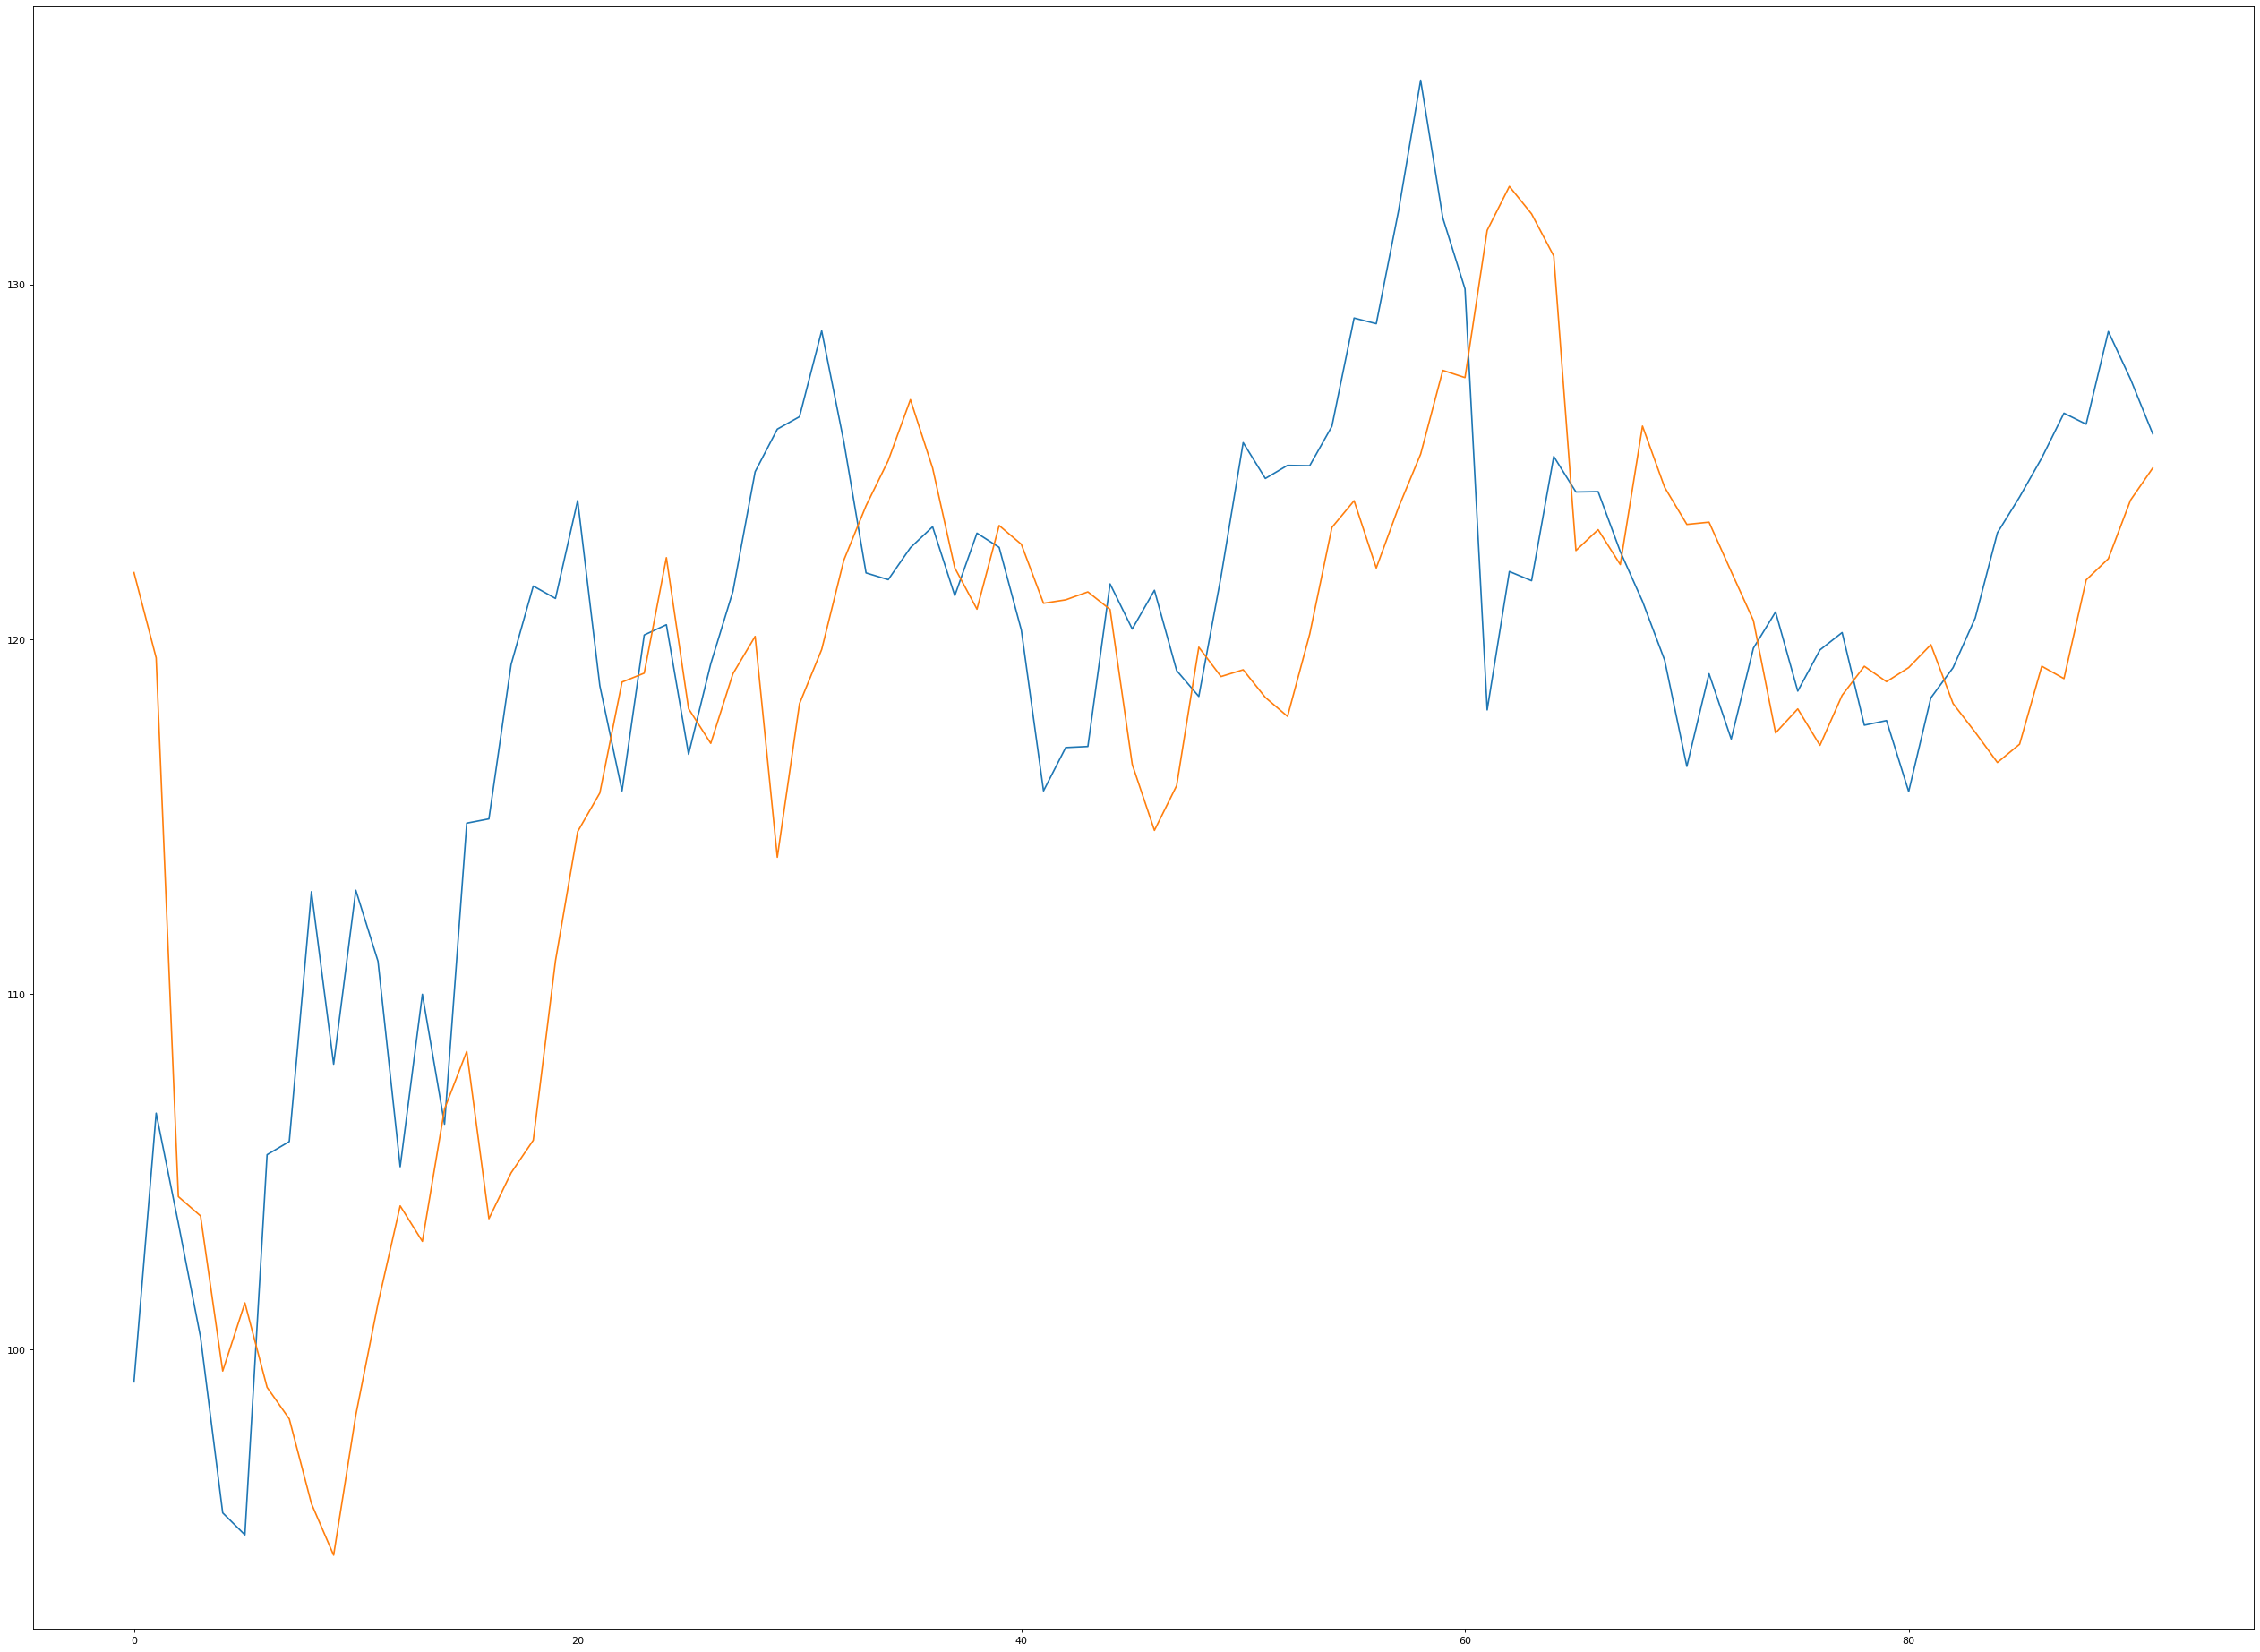

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 16 days + prediction of last 8 days

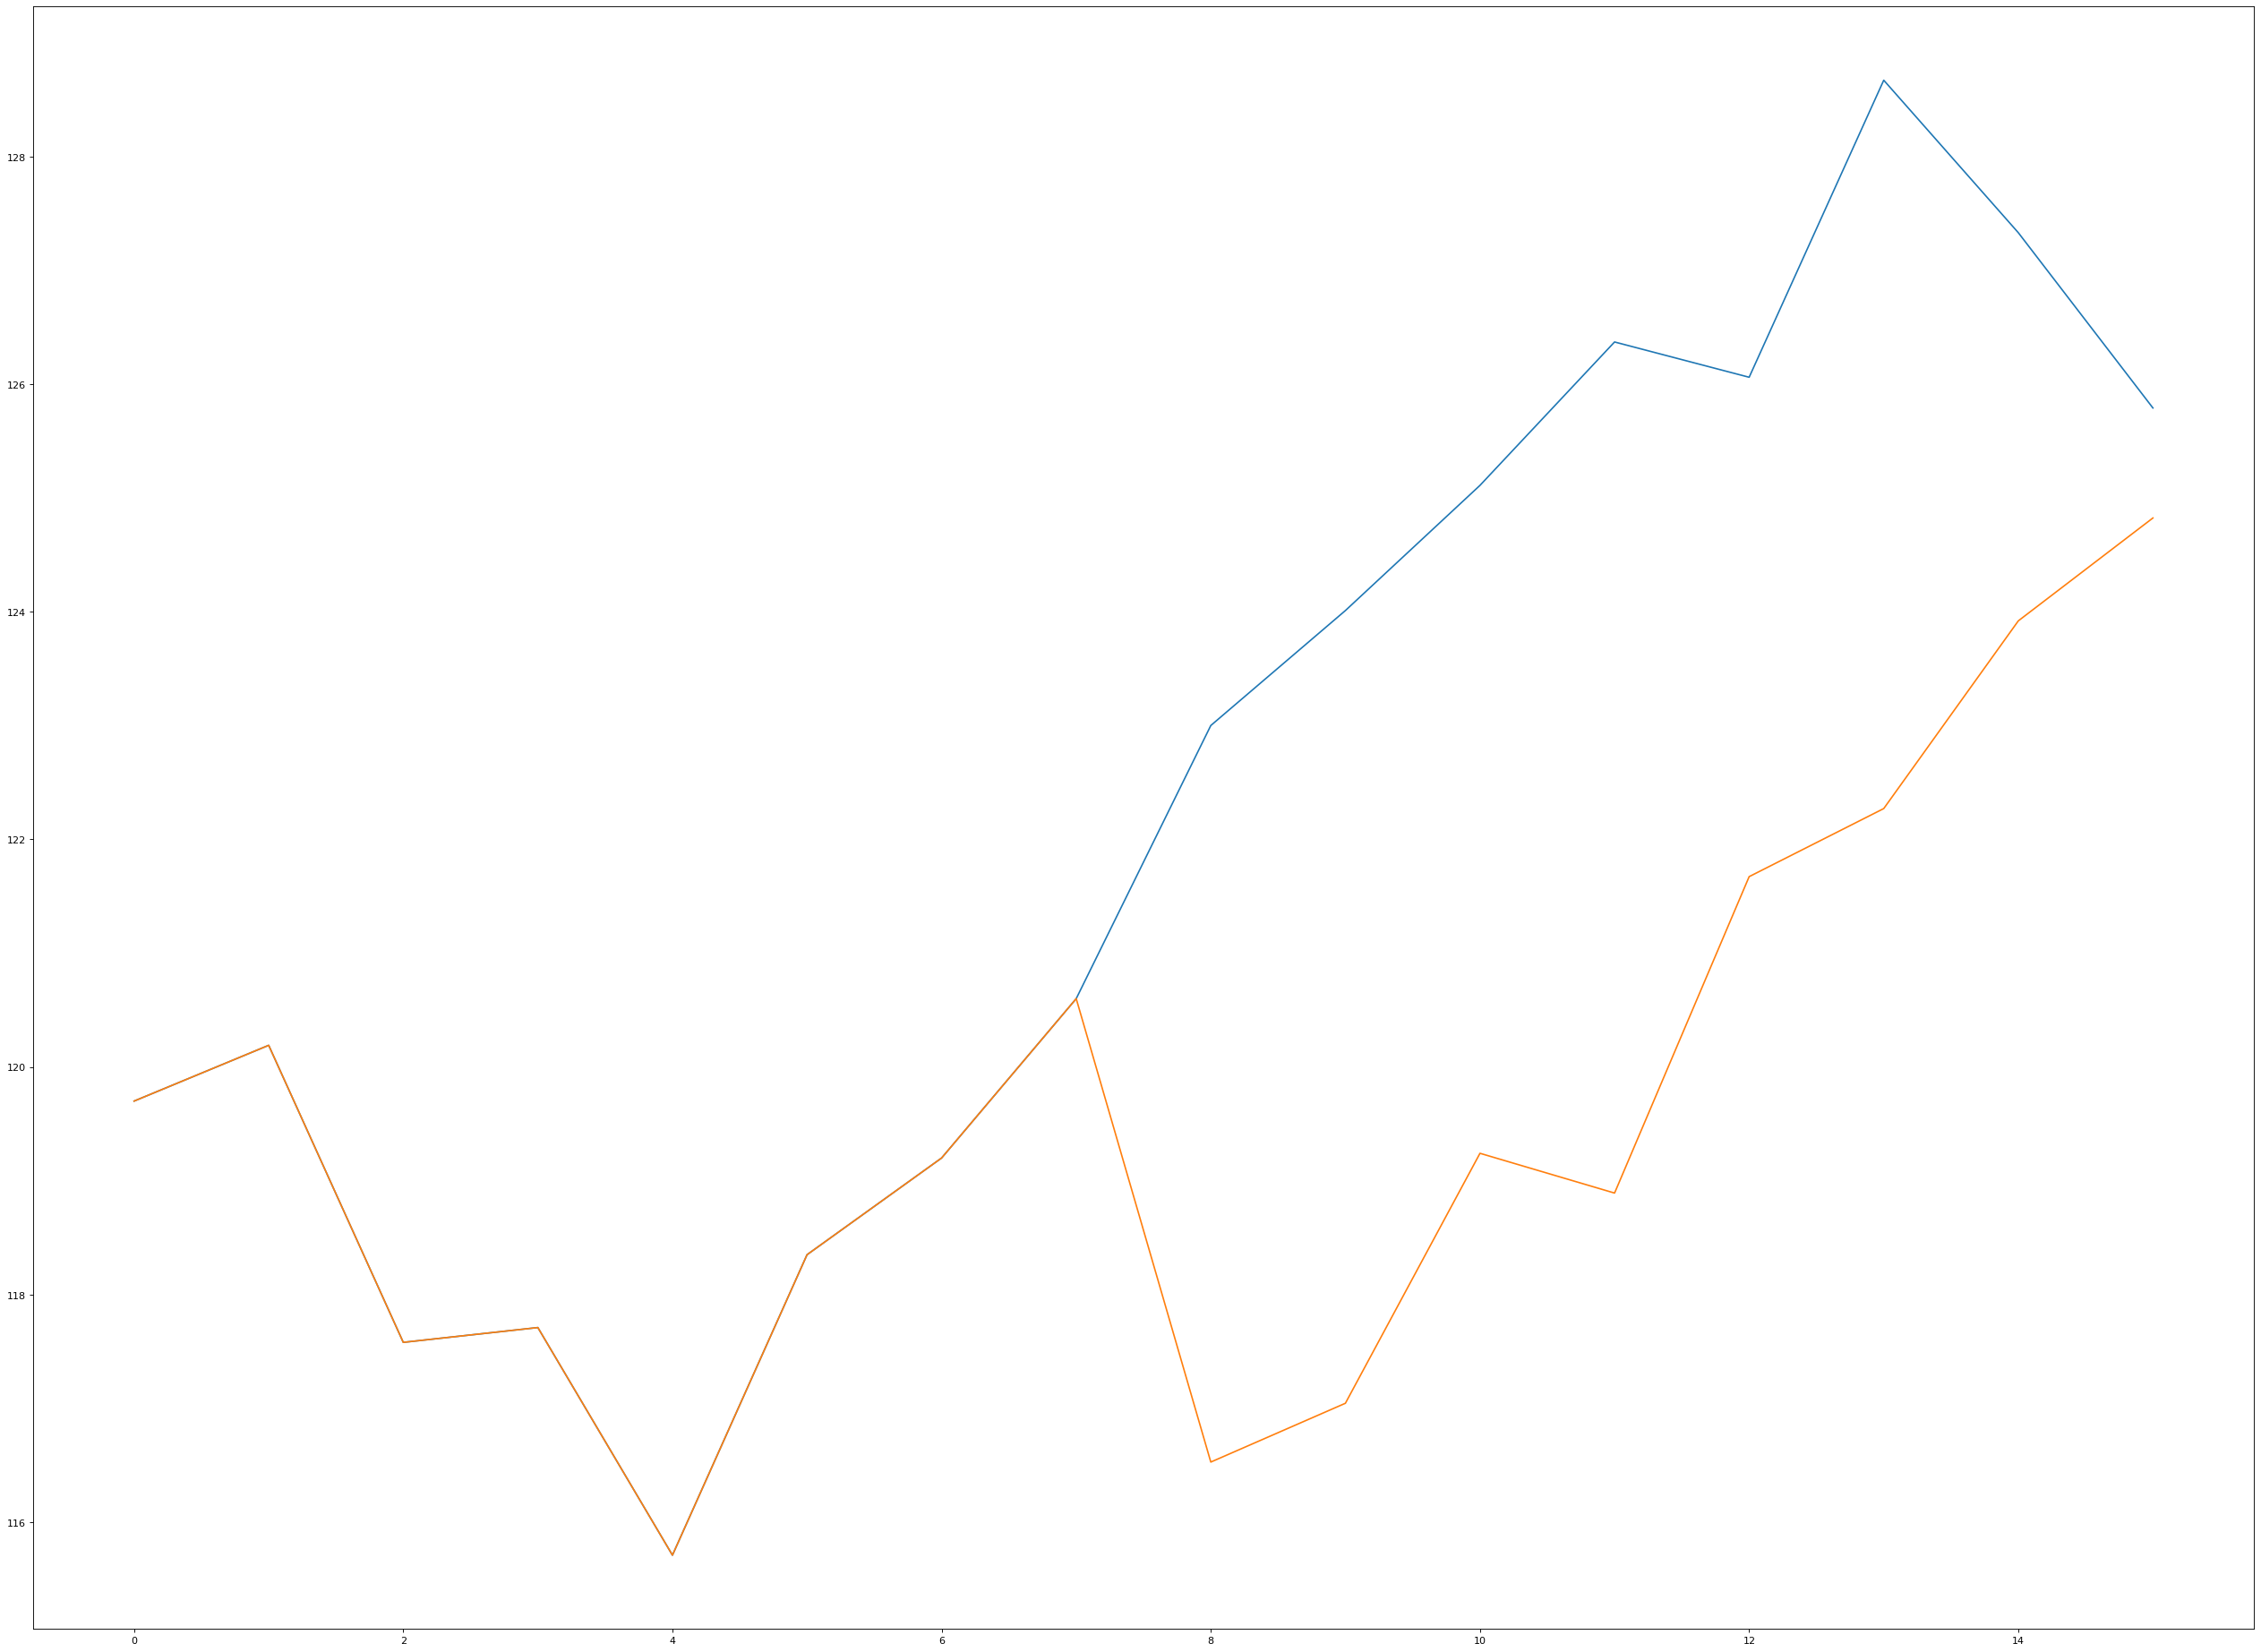

In [36]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(16), true_y_test[-16:])
plt.plot(range(16), np.append(true_y_test[-16:-8], predicted_y_test[-8:]))
plt.show()